In [1]:
file = "data/scraped_data.jsonl"

In [2]:
import json
with open(file, "r") as f:
    lines = f.readlines()
    d = [json.loads(line) for line in lines]

In [3]:
from recipe_optimize.data_model.response_model import Info

id_file = "data/goods_2025-09-25_deduped.jsonl"
with open(id_file, 'r', encoding='utf-8') as f:
    lines = f.readlines()
    infos = [Info.model_validate_json(line) for line in lines]

# excluded ids
data_not_memorized = [i for i in infos if i.data.goods_info.quality_localized_name != "纪念品"]
#### get containers
containers = set(c.name for d in data_not_memorized for c in d.data.container)

import re
regex_co = re.compile(r'收藏品') 
regex_ca = re.compile(r'武器箱')
containers_exclude = {c for c in containers if not any([regex_co.search(c), regex_ca.search(c)])}
available_containers = containers - containers_exclude
available_containers.add('阿努比斯收藏包')

from relevants.cs2_terms import rarity
rarities = rarity.strip().splitlines()
valid_weapons = [w for w in data_not_memorized if any([c.name in available_containers for c in w.data.container]) and w.data.goods_info.rarity_localized_name != "违禁" and w.data.goods_info.rarity_localized_name in rarities]
infos = valid_weapons

In [4]:
# excluded ids
pass

import re
from collections import defaultdict

wear_rank_p = re.compile(r'\s*\(([^)]*)\)\s*$')
# build float range mapping
# first build weapon name and infos tuple
name_infos = defaultdict(list)
for info in infos:
    name = wear_rank_p.sub('', info.data.goods_info.market_hash_name).strip()
    name_infos[name].append(info)

In [5]:
def create_id_float(name_infos):
    id_float_range = {}
    for name, infos in name_infos.items():
        def get_min_max(infos):
            min_float = min(info.data.goods_info.min_float for info in infos if info.data.goods_info.min_float is not None)
            max_float = max(info.data.goods_info.max_float for info in infos if info.data.goods_info.max_float is not None)
            return min_float, max_float
        min_float, max_float = get_min_max(infos)
        for info in infos:
            id_float_range[info.data.goods_info.yyyp_id] = (min_float, max_float)
    return id_float_range
id_float_range = create_id_float(name_infos)

In [6]:
# yyid commodityName price abrade rarity quality container

# first create a yyid to info mapping
info_map = {
    info.data.goods_info.yyyp_id: {
        "rarity": info.data.goods_info.rarity_localized_name,
        "quality": info.data.goods_info.quality_localized_name,
        "container": info.data.container[0].name if info.data.container else None,
    }
    for info in infos
}

In [7]:
import pandas as pd
data = [
    {
        "yyid": item.get("templateId"),
        "commodityName": item.get("commodityName"),
        "price": item.get("price"),
        "abrade": item.get("abrade"),
    }
    for item in d
]
df = pd.DataFrame(data)

In [8]:
df['rarity'] = df['yyid'].map(lambda yyid: info_map.get(yyid, {}).get('rarity'))
df['quality'] = df['yyid'].map(lambda yyid: info_map.get(yyid, {}).get('quality'))
df['container'] = df['yyid'].map(lambda yyid: info_map.get(yyid, {}).get('container'))
df['min_float'] = df['yyid'].map(lambda yyid: id_float_range.get(yyid)[0])
df['max_float'] = df['yyid'].map(lambda yyid: id_float_range.get(yyid)[1])

In [9]:
df = df[~df.duplicated()]
df

,yyid,commodityName,price,abrade,rarity,quality,container,min_float,max_float
0,103577,MAG-7 | 鎏铜 (崭新出厂),42.5,0.0049325688742101190,军规级,普通,阿努比斯收藏包,0.0,1.0
1,103577,MAG-7 | 鎏铜 (崭新出厂),42,0.0137166725471615790,军规级,普通,阿努比斯收藏包,0.0,1.0
2,103577,MAG-7 | 鎏铜 (崭新出厂),40.8,0.0232761558145284650,军规级,普通,阿努比斯收藏包,0.0,1.0
3,103577,MAG-7 | 鎏铜 (崭新出厂),41.3,0.0320337414741516100,军规级,普通,阿努比斯收藏包,0.0,1.0
4,103577,MAG-7 | 鎏铜 (崭新出厂),40.88,0.0486001670360565200,军规级,普通,阿努比斯收藏包,0.0,1.0
...,...,...,...,...,...,...,...,...,...
92241,2250,UMP-45 | 动量 (崭新出厂),342.98,0.0245935823768377300,保密,普通,“头号特训”武器箱,0.0,0.5
92242,2250,UMP-45 | 动量 (崭新出厂),160,0.0323861837387084960,保密,普通,“头号特训”武器箱,0.0,0.5
92243,2250,UMP-45 | 动量 (崭新出厂),140,0.0444567166268825500,保密,普通,“头号特训”武器箱,0.0,0.5
92244,2250,UMP-45 | 动量 (崭新出厂),115.5,0.0505115464329719540,保密,普通,“头号特训”武器箱,0.0,0.5


In [10]:
import numpy as np

# Convert 'abrade' and 'price' columns to float
df['abrade'] = pd.to_numeric(df['abrade'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Drop rows with missing abrade, price, or float-range info (min_float/max_float)
filtered_df = df.dropna(subset=['abrade', 'price', 'min_float', 'max_float']).copy()

# Compute scaled abrade: new_abrade = abrade / (max_float - min_float)
denom = filtered_df['max_float'] - filtered_df['min_float']
# Avoid division by zero or non-positive ranges: replace 0 or negative with NaN so they are dropped
denom = denom.where(denom > 0, np.nan)
filtered_df['new_abrade'] = filtered_df['abrade'] / denom

# Drop rows where new_abrade is NaN or infinite
filtered_df = filtered_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['new_abrade'])

# Create abrade bins based on new_abrade and ensure 0-0.01 bin exists
# Determine the max upper bound from data but ensure at least 0.01 so the 0-0.01 bin exists
max_upper = filtered_df['new_abrade'].max() if not filtered_df['new_abrade'].empty else 0.01
max_upper = max(max_upper, 0.01)
# Build bins from 0 to max_upper with 0.01 steps (include a small extra step to capture the top edge)
bins = np.arange(0, max_upper + 0.01, 0.01)
labels = [f"{round(bins[i],2)}-{round(bins[i+1],2)}" for i in range(len(bins)-1)]
filtered_df.loc[:, 'abrade_bin'] = pd.cut(filtered_df['new_abrade'], bins=bins, labels=labels, include_lowest=True, right=False)

# Group and find lowest price row for each group (using scaled abrade bins)
result = (
    filtered_df
    .sort_values('price')
    .groupby(['quality', 'container', 'rarity', 'abrade_bin'], as_index=False, observed=True)
    .first()
)

result

,quality,container,rarity,abrade_bin,yyid,commodityName,price,abrade,min_float,max_float,new_abrade
0,StatTrak™,“九头蛇大行动”武器箱,保密,0.01-0.02,1257,加利尔 AR（StatTrak™） | ~甜甜的~ (崭新出厂),4000.0,0.005935,0.0,0.45,0.013189
1,StatTrak™,“九头蛇大行动”武器箱,保密,0.02-0.03,49762,M4A4（StatTrak™） | 地狱烈焰 (崭新出厂),9999.0,0.010633,0.0,0.50,0.021266
2,StatTrak™,“九头蛇大行动”武器箱,保密,0.03-0.04,49762,M4A4（StatTrak™） | 地狱烈焰 (崭新出厂),6666.0,0.017797,0.0,0.50,0.035594
3,StatTrak™,“九头蛇大行动”武器箱,保密,0.04-0.05,49762,M4A4（StatTrak™） | 地狱烈焰 (崭新出厂),6666.0,0.021667,0.0,0.50,0.043335
4,StatTrak™,“九头蛇大行动”武器箱,保密,0.05-0.06,49762,M4A4（StatTrak™） | 地狱烈焰 (崭新出厂),16666.0,0.028700,0.0,0.50,0.057400
...,...,...,...,...,...,...,...,...,...,...,...
18160,普通,阿努比斯收藏包,受限,0.95-0.96,103584,P90 | 疾袭圣甲虫 (战痕累累),27.0,0.955787,0.0,1.00,0.955787
18161,普通,阿努比斯收藏包,受限,0.96-0.97,103531,新星 | 索贝克之噬 (战痕累累),27.5,0.966355,0.0,1.00,0.966355
18162,普通,阿努比斯收藏包,受限,0.97-0.98,103584,P90 | 疾袭圣甲虫 (战痕累累),22.0,0.977832,0.0,1.00,0.977832
18163,普通,阿努比斯收藏包,受限,0.98-0.99,103584,P90 | 疾袭圣甲虫 (战痕累累),22.5,0.982625,0.0,1.00,0.982625


In [11]:
# result.to_csv('price.csv', index=False)

In [12]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# For macOS
rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Heiti TC', 'PingFang HK']
# For Windows, use: ['Microsoft YaHei', 'SimHei']
# For Linux, use: ['Noto Sans CJK', 'WenQuanYi Micro Hei']

rcParams['axes.unicode_minus'] = False  # Fix minus sign display

In [ ]:
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

def show_monotonic_fits(i, rel_tol=0.05):
    """Plot price vs scaled abrade (new_abrade) for group index i.
    Removes points that do not comply with a monotonic-decreasing trend (greedy filter).
    rel_tol: relative tolerance (fraction) allowed for small increases (default 5%).
    
    Returns:
        A function that takes x values and returns predicted y values based on the fit,
        or None if fitting failed.
    """
    for index, (name, group) in enumerate(result.groupby(['quality', 'container', 'rarity'])):
        # use scaled abrade produced earlier
        group = group.dropna(subset=['new_abrade', 'price'])
        if index != i:
            continue
        if len(group) < 10:
            continue
        # Sort by scaled abrade
        group = group.sort_values('new_abrade')
        x = group['new_abrade'].values
        y = group['price'].values
        # Greedy monotonic-decrease filter: keep first point, then keep subsequent points only if they are <= last_kept * (1 + rel_tol)
        keep = []
        last_kept_y = None
        for yi in y:
            if last_kept_y is None:
                keep.append(True)
                last_kept_y = yi
            else:
                # allow small increases up to rel_tol fraction
                if yi <= last_kept_y * (1 + rel_tol):
                    keep.append(True)
                    last_kept_y = yi
                else:
                    keep.append(False)
        keep = np.array(keep, dtype=bool)
        x_clean = x[keep]
        y_clean = y[keep]
        if len(x_clean) < 5:
            # not enough points after filtering
            continue
        # Exponential decay fit on cleaned (monotonic) data
        try:
            popt, _ = curve_fit(exp_decay, x_clean, y_clean, maxfev=10000)
            x_fit = np.linspace(x_clean.min(), x_clean.max(), 100)
            y_exp_fit = exp_decay(x_fit, *popt)
            
            # Create a fitted function to return
            def fitted_curve(x_new):
                return exp_decay(x_new, *popt)
            
        except Exception:
            y_exp_fit = None
            fitted_curve = None
        
        # Plot
        plt.figure(figsize=(7,5))
        plt.scatter(x, y, alpha=0.25, label='Raw Data')
        plt.scatter(x_clean, y_clean, color='orange', label='Monotonic-cleaned Data')
        if y_exp_fit is not None:
            plt.plot(x_fit, y_exp_fit, color='green', label='Exponential Decay Fit')
        # If you still want a reference at original abrade=0.07, note this is unscaled; omit or adjust as needed
        plt.title(f'Price vs Scaled Abrade\nQuality: {name[0]}, Container: {name[1]}, Rarity: {name[2]}')
        plt.xlabel('Scaled Abrade (new_abrade)')
        plt.ylabel('Price')
        plt.legend()
        plt.show()
        
        return fitted_curve
    
    return None  # If no group matched or all failed

In [ ]:
fitted_func = show_monotonic_fits(50)

In [20]:
from scipy.optimize import least_squares

def two_exp(x, a1, b1, a2, b2, c):
    return c + a1 * np.exp(-b1 * x) + a2 * np.exp(-b2 * x)

def show_monotonic_fits(i, rel_tol=0.05, knee_center=0.07, knee_window=0.01, lam_knee=10.0, use_local_weights=True):
    for index, (name, group) in enumerate(result.groupby(['quality','container','rarity'])):
        if index != i: continue
        group = group.dropna(subset=['new_abrade','price']).sort_values('new_abrade')
        if len(group) < 10: continue

        x = group['new_abrade'].values
        y = group['price'].values

        # monotone-decrease filter
        keep, last = [], None
        for yi in y:
            if last is None or yi <= last * (1 + rel_tol):
                keep.append(True); last = yi
            else:
                keep.append(False)
        keep = np.array(keep, bool)
        x_clean, y_clean = x[keep], y[keep]
        if len(x_clean) < 5: continue

        # target y just right of knee (x < knee_center)
        mask_right = (x_clean < knee_center) & (x_clean >= knee_center - knee_window)
        if np.any(mask_right):
            idx = np.argmin(np.abs(x_clean[mask_right] - knee_center))
            y_target = y_clean[mask_right][idx]
        else:
            lt = x_clean < knee_center
            y_target = y_clean[lt][np.argmax(x_clean[lt])] if np.any(lt) else None

        # emphasize around the knee
        if use_local_weights:
            w = np.exp(-0.5 * ((x_clean - knee_center)/max(knee_window,1e-6))**2)
            w = 0.2 + 0.8*w
        else:
            w = np.ones_like(x_clean)

        # initial guess: one slow and one fast exponential
        a1_0 = max(y_clean[0] - y_clean[-1], 1e-6)
        b1_0 = 5.0
        a2_0 = a1_0 * 0.5
        b2_0 = 60.0  # sharper component to form a knee
        c0   = max(min(y_clean[-1], y_clean.mean()), 0.0)
        theta0 = np.array([a1_0, b1_0, a2_0, b2_0, c0])

        # bounds: keep parameters ≥0 and b2 > b1 for a clear knee
        lb = np.array([0.0,  0.0,  0.0,  10.0, 0.0])
        ub = np.array([np.inf, 40.0, np.inf, 200.0, np.inf])

        def residuals(theta):
            a1, b1, a2, b2, c = theta
            y_pred = two_exp(x_clean, a1, b1, a2, b2, c)
            r = (y_pred - y_clean) * np.sqrt(w)
            if y_target is not None:
                r_knee = lam_knee * (two_exp(np.array([knee_center]), a1, b1, a2, b2, c)[0] - y_target)
                return np.concatenate([r, np.array([r_knee])])
            return r

        res = least_squares(residuals, theta0, bounds=(lb, ub), method='trf')
        a1, b1, a2, b2, c = res.x

        # plotting and returning the callable
        x_fit = np.linspace(x_clean.min(), x_clean.max(), 300)
        y_fit = two_exp(x_fit, a1, b1, a2, b2, c)

        plt.figure(figsize=(7,5))
        plt.scatter(x, y, alpha=0.25, label='Raw')
        plt.scatter(x_clean, y_clean, color='orange', label='Monotone-cleaned')
        plt.axvline(knee_center, ls='--', alpha=0.4, label=f'knee~{knee_center}')
        plt.plot(x_fit, y_fit, label='Two-exp convex fit')
        if y_target is not None:
            plt.scatter([knee_center],[y_target], marker='x', s=80, label='Target @ 0.07')
        plt.title(f'Price vs Scaled Abrade\nQ: {name[0]}, C: {name[1]}, R: {name[2]}')
        plt.xlabel('Scaled Abrade'); plt.ylabel('Price'); plt.legend(); plt.show()

        def fitted_curve(x_new):
            return two_exp(np.asarray(x_new), a1, b1, a2, b2, c)
        return fitted_curve
    return None


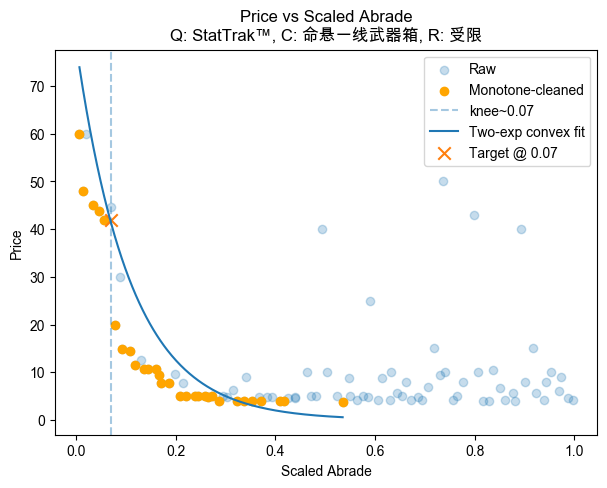

<function __main__.show_monotonic_fits.<locals>.fitted_curve(x_new)>

In [22]:
show_monotonic_fits(50)